In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

from IPython.display import clear_output
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255
    input_mask -= 1
    
    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], 
                                 (128,128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [5]:
tr_d = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
te_d = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
class Augmentation(tf.keras.layers.Layer):
    def __init__(self, seed=777):
        super().__init__()
        # both use the same seed, so they will make the same random change
        self.augment_inputs = tf.keras.layers.RandomFlip(mode='horizontal', seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode='horizontal', seed=seed)
        
    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        
        return inputs, labels

In [7]:
tr_batches = (
    tr_d
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augmentation())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

te_batches = te_d.batch(BATCH_SIZE)

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    
    plt.show()

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


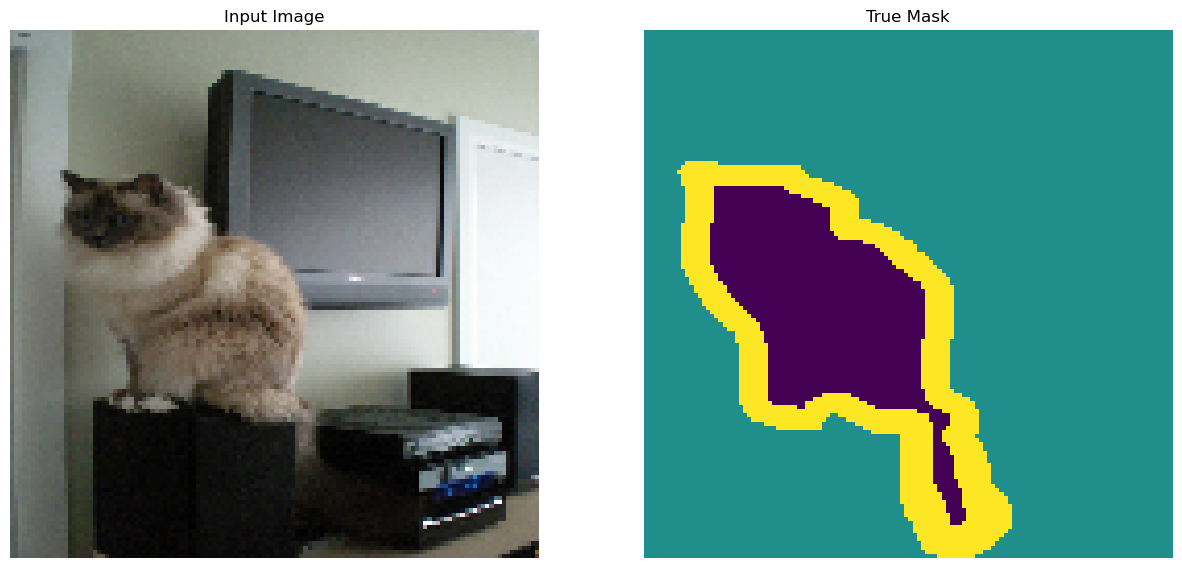

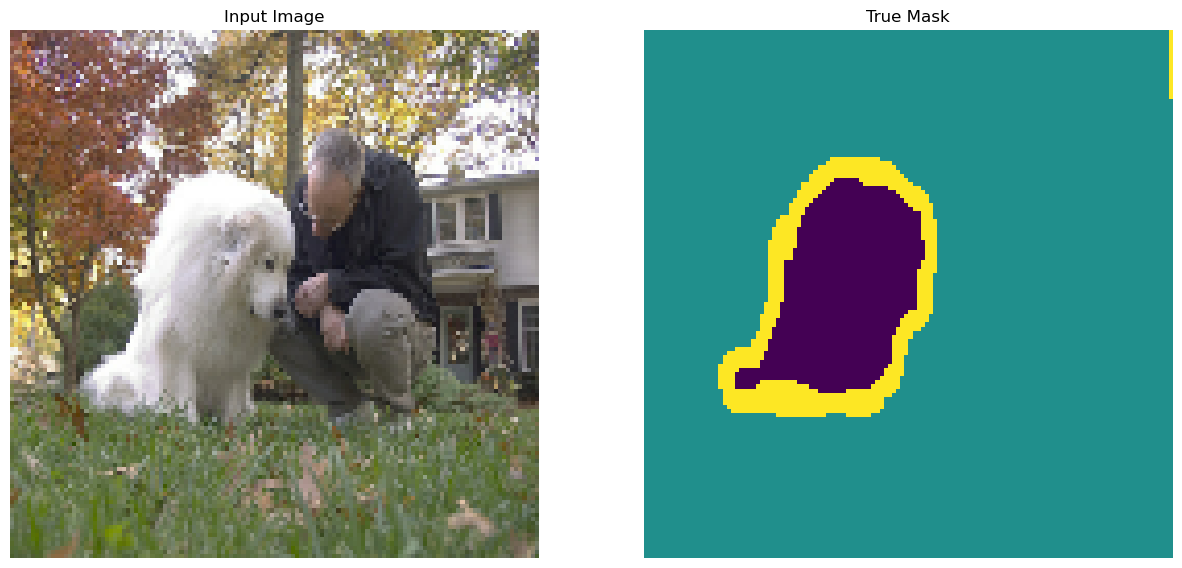

In [11]:
for images, masks in tr_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

### The model

In [12]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [13]:
print(f"Number of GPUs: {strategy.num_replicas_in_sync}")

Number of GPUs: 2


In [24]:
with strategy.scope():
    inputs = keras.Input(shape=(128,128,3))
    
    x = layers.Rescaling(1./255)(inputs)
    
    # for size in [64,128,256]:a
    #     x = layers.Conv2D(size, 3, strides=2, padding='same', activation='relu')(x)
    #     x = layers.Conv2D(size, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    
    x = layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    
        
    # for size in [256, 128, 64]:
    #     x = layers.Conv2DTranspose(size, 3, padding='same', activation='relu')(x)
    #     x = layers.Conv2DTranspose(size, 3, strides=2, padding='same', activation='relu')(x)
    
    x = layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
    
    x = layers.Conv2DTranspose(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    
    x = layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    
    outputs = layers.Conv2D(3, 3, padding='same', activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer='rmsprop',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 3s 3s/step


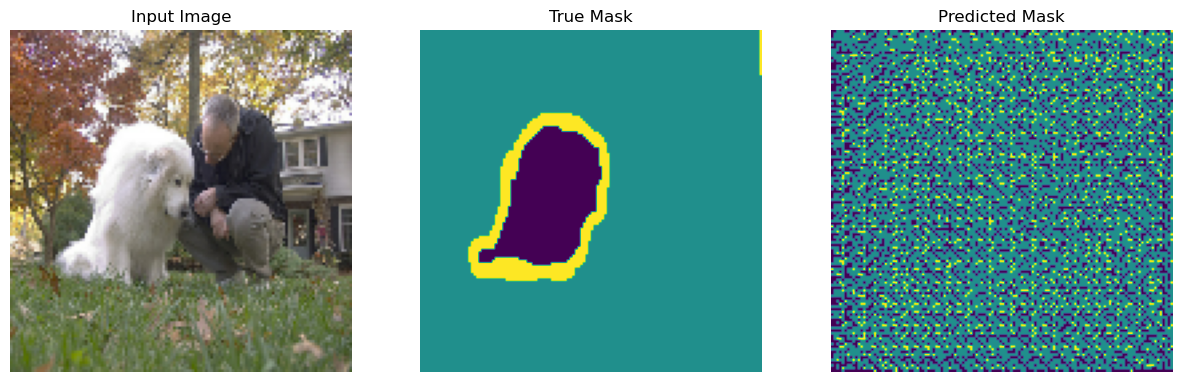

In [25]:
show_predictions()

In [26]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 125ms/step


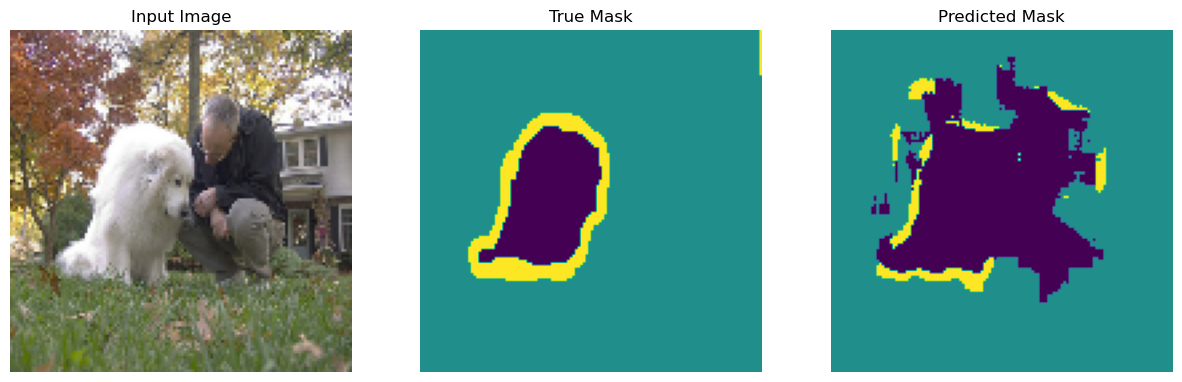


Sample Prediction after epoch 52

57/57 [==============================] - 11s 191ms/step - loss: 0.4407 - accuracy: 0.8257 - val_loss: 0.5453 - val_accuracy: 0.7886


In [29]:
EPOCHS = 52
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(tr_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=te_batches,
                          callbacks=[DisplayCallback()])